### Random Walk
1. 문제: 7개의 node가 일렬로 있는데 4번째(가운데)에서 출발해서 random하게 움직이며 좌측 혹은 우측 끝에 도달하면 끝나는 문제이다. 
2. 조건: 
    - state: 말의 node 위치
    - action: 좌, 우 이동 
    - reward: 우측 끝에 도달(+1), 나머지 움직임(0)
    - terminal: 좌측, 우측 끝에 도달
    - start: C(3) node 
    - policy: random policy
3. 학습 목표
    - TD(0) prediction 의 true value function으로의 수렴 여부 확인 
    - MC, TD(0) prediction 각각의 $\alpha$를 변경함에 따른 성능 변화 관찰
    - MC, TD(0) prediction 간의 성능 비교
4. 궁금한 점
    - 마지막 state에 도달했을 때를 어떻게 처리해줘야 하지? 이전에 다뤘던 cliff walking, grid world 처럼 마지막 state에 도달할 때 까지의 action에 대한 reward를 매기고 도달한 다음에 action에 대해 reward를 반영하면 값이 너무 크게 나온다. (TD 로직 상 undiscounted로 진행되면 그냥 $\alpha \cdot R$이 더해지게 된다.)
    - MC method의 경우에는 다음 state의 V나 reward를 고려할 일이 없어서 (전체 episode 중에 terminal reward는 결국 1번만 반영되게 되어 있음.) 기존처럼 해도 상관없다.

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
true_V = np.arange(7) / 6

In [3]:
START = 3
A = 1
E = 5
LEFT = 0
RIGHT = 1

class RandomWalk:
    def __init__(self):
        self.state = START
        self.nA = 2
        self.nS = 7
        grid = np.arange(self.nS)
        P = defaultdict(lambda: [[] for i in range(self.nA)])

        for s in grid:
            if s == E:
                P[s][LEFT] = [1.0, s - 1, 0, False]
                P[s][RIGHT] = [1.0, s + 1, 0, True]
            elif s == A:
                P[s][LEFT] = [1.0, s - 1, 0, True]
                P[s][RIGHT] = [1.0, s + 1, 0, False]
            else:
                P[s][LEFT] = [1.0, s - 1, 0, False]
                P[s][RIGHT] = [1.0, s + 1, 0, False]
        self.P = P
        
    def step(self, action):            
        prob, next_state, reward, done = self.P[self.state][action]
        self.state = next_state
        return [prob, next_state, reward, done]
        
    def reset(self):
        self.state = START
        return self.state

In [4]:
def tabular_td_zero(env, num_episodes, policy, discount_factor, alpha):
    V = np.zeros(env.nS)
    rmse = []
    V[6] = 1.0
    V[1:6] = 0.5
    for i_episode in range(num_episodes):
        state = env.reset()
        while True:            
            action = policy()
            prob, next_state, reward, done = env.step(action)
            V[state] += alpha * (reward + discount_factor * V[next_state] - V[state])
            if done:
                break
            state = next_state
        rmse.append(np.sqrt(np.sum(np.square(true_V - V))))
    return V, rmse

In [5]:
env = RandomWalk()
policy = lambda: np.random.binomial(1, 0.5)
V, rmse = tabular_td_zero(env, 1000, policy, 1.0, 0.1)

In [6]:
V

array([ 0.        ,  0.16696713,  0.34483561,  0.52410709,  0.74616056,
        0.88519786,  1.        ])

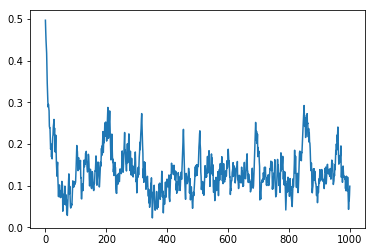

In [7]:
plt.plot(np.arange(1000), rmse)
plt.show()

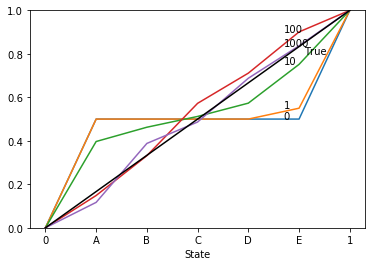

In [8]:
V_sum = []
for num_episodes in [0, 1, 10, 100, 1000]:
    V, rmse = tabular_td_zero(env, num_episodes, policy, 1.0, 0.1)
    V_sum.append(V)
    plt.plot(np.arange(len(V)), V)
    plt.annotate(num_episodes, [4.7, V[5]])
plt.plot(true_V, c = 'k')
plt.annotate('True', [5.1, 0.8])
plt.xticks(np.arange(len(V)), ['0', 'A', 'B', 'C', 'D', 'E', '1'])
plt.xlabel('State')
plt.ylim([0, 1])
plt.show()

### MC prediction

In [9]:
START = 3
A = 1
E = 5
LEFT = 0
RIGHT = 1

class RandomWalk_MC:
    def __init__(self):
        self.state = START
        self.nA = 2
        self.nS = 7
        grid = np.arange(self.nS)
        P = defaultdict(lambda: [[] for i in range(self.nA)])
        for s in grid:
            if s == 6:
                P[s][LEFT] = P[s][RIGHT] = [1.0, s, 1, True]
            elif s == 0:
                P[s][LEFT] = P[s][RIGHT] = [1.0, s, 0, True]
            else:
                P[s][LEFT] = [1.0, s - 1, 0, False]
                P[s][RIGHT] = [1.0, s + 1, 0, False]
        self.P = P
        
    def step(self, action):
        prob, next_state, reward, done = self.P[self.state][action]
        self.state = next_state
        return [prob, next_state, reward, done]
        
    def reset(self):
        self.state = START
        return self.state

In [10]:
def mc_prediction(env, num_episodes, policy, discount_factor, alpha):
    rmse = []
    V = np.zeros(env.nS)
    V[1:5] = 0.5
    V[6] = 1
    
    for i_episode in range(num_episodes):
        episode = []
        state = env.reset()
        while True:
            action = policy()
            prob, next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state
            if done:
                break        
        for i, (state, reward) in enumerate(episode):
            G = sum(x[1]*(discount_factor**i) for x in episode[i:])
            V[state] += alpha * (G - V[state])    
        rmse.append(np.sqrt(np.square(np.sum(V - true_V))))
    return V, rmse

In [11]:
env = RandomWalk_MC()
policy = lambda: np.random.binomial(1, 0.5)
V, rmse = mc_prediction(env, 1000, policy, 1.0, 0.01)

In [12]:
V

array([ 0.        ,  0.11902404,  0.27534912,  0.41612695,  0.56732567,
        0.81443733,  1.        ])

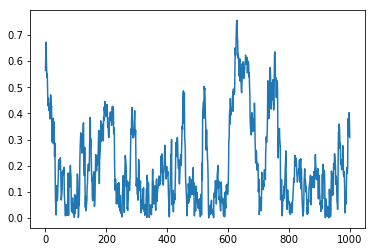

In [13]:
plt.plot(np.arange(1000), rmse)
plt.show()

### RMS error 비교

In [14]:
def mc_graph(num_episodes=100, alphas=[0.01, 0.02, 0.03, 0.04], discount_factor=1.0):
    env = RandomWalk_MC()
    policy = lambda: np.random.binomial(1, 0.5)
    for a in alphas:
        V, rmse = mc_prediction(env, num_episodes, policy, discount_factor, a)
        plt.plot(np.arange(num_episodes), rmse)    
    plt.show()

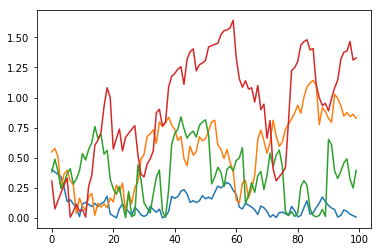

In [15]:
mc_graph()